<a href="https://colab.research.google.com/github/teja1091/Alzheimer-s---deep-learning/blob/main/Alzheimer_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
uraninjo_augmented_alzheimer_mri_dataset_path = kagglehub.dataset_download('uraninjo/augmented-alzheimer-mri-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import keras


In [ ]:
import os
import pandas as pd

# Define base dataset path
base_path = uraninjo_augmented_alzheimer_mri_dataset_path + '/AugmentedAlzheimerDataset'

# Map subfolders to their respective labels
class_map = {
    'MildDemented': 'Mild Demented',
    'ModerateDemented': 'Moderate Demented',
    'NonDemented': 'Non Demented',
    'VeryMildDemented': 'Very MildDemented'
}

filepaths = []
labels = []

# Loop through each class folder and collect file paths and labels
for folder_name, label in class_map.items():
    folder_path = os.path.join(base_path, folder_name)

    if not os.path.isdir(folder_path):
        print(f"Warning: {folder_path} does not exist.")
        continue

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):  # Ensure it's a file
            filepaths.append(file_path)
            labels.append(label)

# Create the DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Display sample and class distribution
print(df.head())
print(df['labels'].value_counts())


                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [ ]:
train_images, test_images = train_test_split(df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


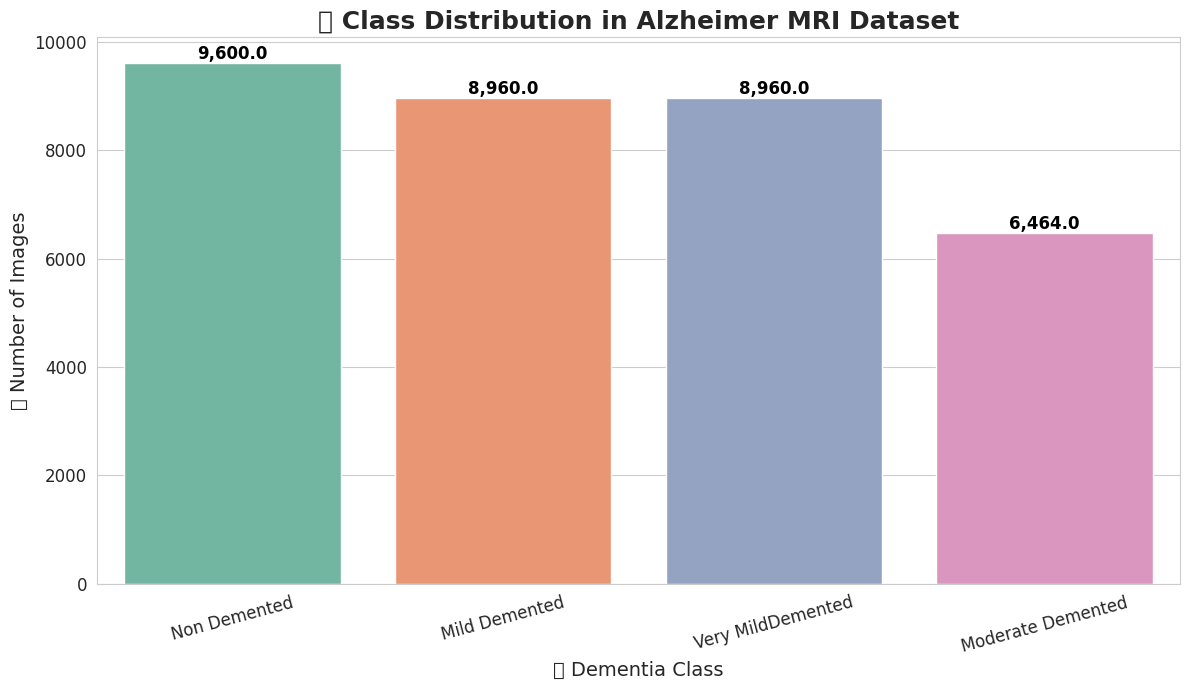

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Create the count plot
ax = sns.countplot(
    data=df,
    x='labels',
    order=df['labels'].value_counts().index,
    palette='Set2'  # You can try "pastel", "husl", etc.
)

# Add value labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',  # Format with commas
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black')

# Titles and labels
plt.title('🧠 Class Distribution in Alzheimer MRI Dataset', fontsize=18, fontweight='bold')
plt.xlabel('🩺 Dementia Class', fontsize=14)
plt.ylabel('📷 Number of Images', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
no_classes=list(train.class_indices.keys())
print (no_classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [ ]:
def images_leg(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

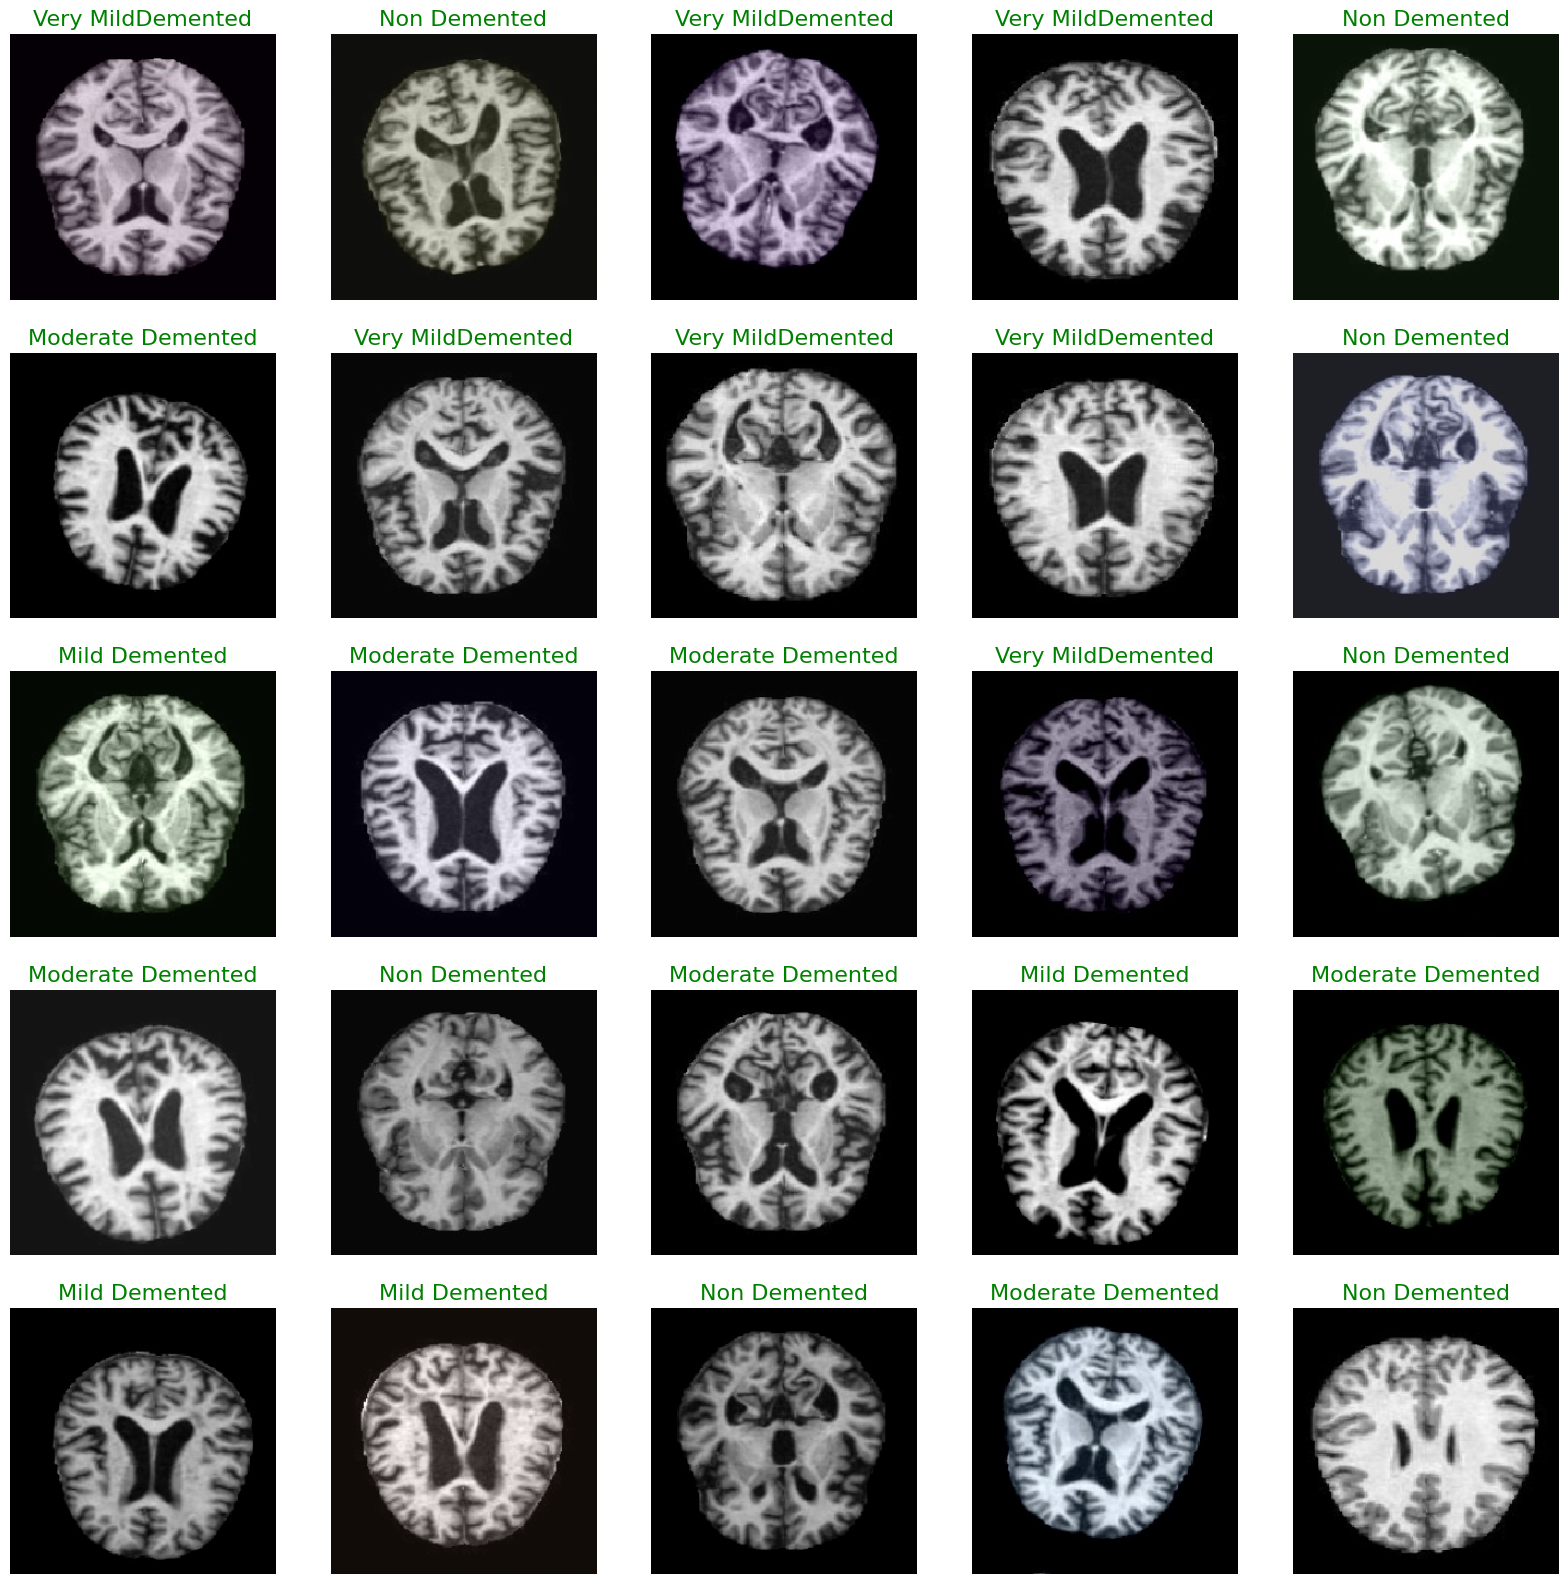

In [ ]:
images_leg(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
history = model.fit(train, epochs=6, validation_data=val, validation_freq=1)

Epoch 1/6
850/850 ━━━━━━━━━━━━━━━━━━━━ 147s 173ms/step - accuracy: 0.7479 - loss: 0.5672 - val_accuracy: 0.7687 - val_loss: 0.5378
Epoch 2/6
850/850 ━━━━━━━━━━━━━━━━━━━━ 201s 172ms/step - accuracy: 0.7868 - loss: 0.4886 - val_accuracy: 0.8062 - val_loss: 0.4633
Epoch 3/6
850/850 ━━━━━━━━━━━━━━━━━━━━ 145s 171ms/step - accuracy: 0.8229 - loss: 0.4148 - val_accuracy: 0.8236 - val_loss: 0.4174
Epoch 4/6
850/850 ━━━━━━━━━━━━━━━━━━━━ 146s 171ms/step - accuracy: 0.8601 - loss: 0.3430 - val_accuracy: 0.8148 - val_loss: 0.4211
Epoch 5/6
850/850 ━━━━━━━━━━━━━━━━━━━━ 145s 171ms/step - accuracy: 0.8863 - loss: 0.2794 - val_accuracy: 0.8554 - val_loss: 0.3564
Epoch 6/6
850/850 ━━━━━━━━━━━━━━━━━━━━ 145s 171ms/step - accuracy: 0.9136 - loss: 0.2214 - val_accuracy: 0.8183 - val_loss: 0.4402


In [ ]:
model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - accuracy: 0.8200 - loss: 0.4402


[0.3605588972568512, 0.8520988821983337]

In [ ]:
model.save("Model.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step


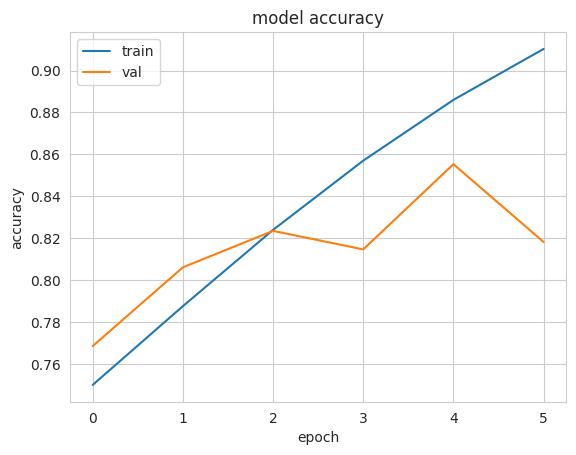

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

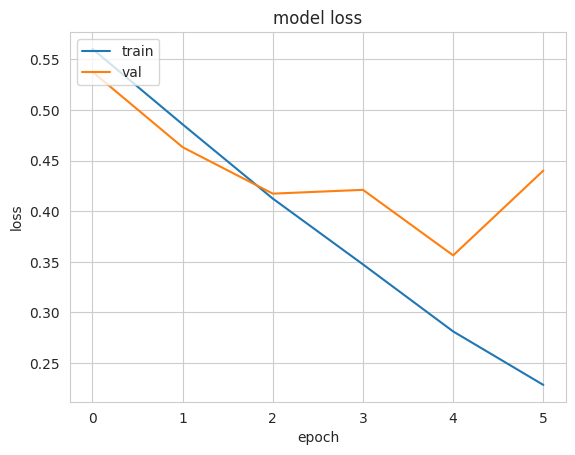

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Mild Demented       0.95      0.83      0.89      2693
Moderate Demented       0.99      1.00      0.99      1977
     Non Demented       0.72      0.94      0.82      2811
Very MildDemented       0.83      0.67      0.74      2715

         accuracy                           0.85     10196
        macro avg       0.87      0.86      0.86     10196
     weighted avg       0.86      0.85      0.85     10196

Accuracy of the Model: 85.2%


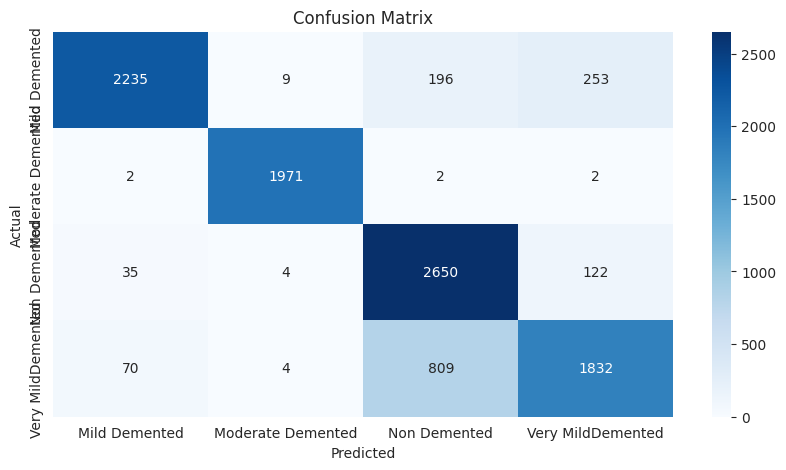

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()